In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, AveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
import tensorflow_model_optimization as tfmot

In [102]:
plt.rcParams["figure.figsize"] = (5,5)

In [103]:
with np.load('mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255 # Normalize pixel values to [0,1] and flatten each image to 1D.
y_train = keras.utils.to_categorical(y_train) # One-hot encoding

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [247]:
def create_base_model():
    raw_model = Sequential()
    raw_model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(16, 16), filters=32, strides=(4, 4), activation='relu', name="conv1"))
    raw_model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1), activation='relu', name="conv2"))
    raw_model.add(Flatten())
    raw_model.add(Dense(10, activation='softmax'))
    return raw_model

def create_lenet():
    lenet_5_model = Sequential([
        Conv2D(filters=6, kernel_size=5, strides=1,  activation='relu', input_shape=(28, 28, 1), padding='same', name="conv1"), #C1
        AveragePooling2D(), #S2
        Conv2D(filters=16, kernel_size=5, strides=1, activation='relu', padding='valid', name="conv2"), #C3
        AveragePooling2D(), #S4
        Flatten(), #Flatten
        Dense(120, activation='tanh'), #C5
        Dense(84, activation='tanh'), #F6
        Dense(10, activation='softmax') #Output layer
    ])
    return lenet_5_model

In [248]:
#model = create_base_model()
model = create_lenet()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_28 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_29 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_47 (Dense)             (None, 84)              

Epoch 1/5
118/118 [==============================] - 8s 61ms/step - loss: 0.9189 - accuracy: 0.7433
Epoch 2/5
118/118 [==============================] - 7s 61ms/step - loss: 0.1944 - accuracy: 0.9418
Epoch 3/5
118/118 [==============================] - 8s 64ms/step - loss: 0.1118 - accuracy: 0.9659
Epoch 4/5
118/118 [==============================] - 7s 62ms/step - loss: 0.0772 - accuracy: 0.9766
Epoch 5/5
118/118 [==============================] - 9s 79ms/step - loss: 0.0676 - accuracy: 0.9796


Text(0, 0.5, 'Accuracy')

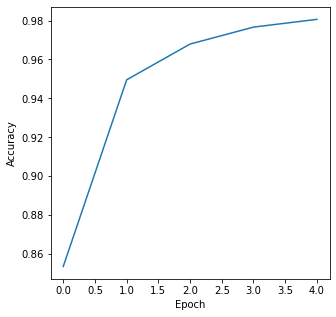

In [249]:
# Fit the model:
model.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [250]:
model.evaluate(x_train.reshape(-1,28,28,1), y_train)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0550 - accuracy: 0.9832


[0.05499739944934845, 0.9832000136375427]

Model prediction: 9


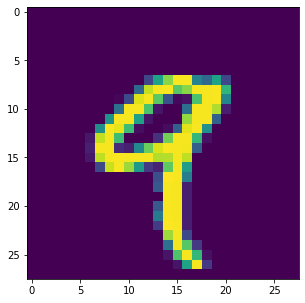

In [251]:
# classify image:
k = 4
image = x_train[k]
y_predict = np.argmax(model.predict(image[None, :,:, None]))

print("Model prediction:", y_predict)
plt.imshow(image.reshape(28, 28))

# Save the model

In [252]:
model.save("mnist.h5")

# Prune the model

In [132]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 5
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

print("end_step:", end_step)

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                               final_sparsity=0.20,
                                                               begin_step=0,
                                                               end_step=end_step)
}

raw_model = create_base_model()
#raw_model.load_weights(pretrained_weights)

model_pruned = prune_low_magnitude(raw_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_pruned.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#model_for_pruning.summary()

end_step: 530


In [133]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  #tfmot.sparsity.keras.PruningSummaries(log_dir="log")
]

model_pruned.fit(x_train.reshape(-1,28,28,1), y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


#%tensorboard --logdir={"log"}

Epoch 1/5
106/106 [==============================] - 2s 16ms/step - loss: 1.0188 - accuracy: 0.7054 - val_loss: 0.2907 - val_accuracy: 0.9215
Epoch 2/5
106/106 [==============================] - 2s 15ms/step - loss: 0.3313 - accuracy: 0.9059 - val_loss: 0.2175 - val_accuracy: 0.9392
Epoch 3/5
106/106 [==============================] - 2s 15ms/step - loss: 0.2502 - accuracy: 0.9284 - val_loss: 0.1627 - val_accuracy: 0.9560
Epoch 4/5
106/106 [==============================] - 2s 14ms/step - loss: 0.1876 - accuracy: 0.9450 - val_loss: 0.1324 - val_accuracy: 0.9628
Epoch 5/5
106/106 [==============================] - 1s 14ms/step - loss: 0.1500 - accuracy: 0.9563 - val_loss: 0.1216 - val_accuracy: 0.9657


In [134]:
model_pruned_export = tfmot.sparsity.keras.strip_pruning(model_pruned)

In [135]:
total_weights = 0
total_weights_0 = 0

for idx, layer in enumerate(model_pruned.layers):
    weights_layer = 0
    weights_0 = 0
    
    if len(layer.weights) == 0:
        continue

    for weight in np.nditer(layer.weights):
        if type(weight) != tuple:
            continue

        weights_layer += 1
        if weight[0] == 0:
            weights_0 += 1

    print("Layer: ", idx, "Zero weights:", weights_0, "/", weights_layer)
    total_weights += weights_layer
    total_weights_0 += weights_0

print("Total 0-weights:", total_weights_0, "/", total_weights, " => ", (total_weights_0 / total_weights) * 100, "%")

Layer:  0 Zero weights: 1639 / 8192
Layer:  1 Zero weights: 3687 / 18432
Layer:  2 Zero weights: 0 / 0
Layer:  3 Zero weights: 512 / 2560
Total 0-weights: 5838 / 29184  =>  20.004111842105264 %


# Quantize the model

In [96]:
def representative_dataset_gen():
  for i in range(100):
    yield [x_train[i].reshape(-1,28,28,1).astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned_export)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpxpj3c0bn/assets


INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpxpj3c0bn/assets
2022-01-12 17:42:25.481094: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-01-12 17:42:25.481426: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-01-12 17:42:25.483015: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-01-12 17:42:25.676464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-01-12 17:42:25.676481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


17872

# Test the tflite model

In [97]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_quantization_parameters = input_details[0]['quantization_parameters']
output_quantization_parameters = output_details[0]['quantization_parameters']

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])
print("quantization scale:", input_quantization_parameters['scales'])
print("quantization zero point:", input_quantization_parameters['zero_points'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])
print("quantization scale:", output_quantization_parameters['scales'])
print("quantization zero point:", output_quantization_parameters['zero_points'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: conv1_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

== Output details ==
name: Identity
shape: [ 1 10]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

DUMP INPUT
{'name': 'conv1_input', 'index': 13, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'Identity', 'index': 14, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


### Accuracy

In [98]:
def predict(interpreter, input_data):
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    return output_data


def measure_accuracy(interpreter, samples = len(x_train)):
    output_data = []

    for idx, sample in enumerate(x_train[:samples]):
        input_data = np.array(sample, dtype=np.float32)
        input_data = np.expand_dims(input_data, axis=0)
        input_data = np.expand_dims(input_data, axis=3)
        output_data.append(predict(interpreter, input_data))

    a = [np.argmax(y, axis=None, out=None) for y in output_data]
    b = [np.argmax(y, axis=None, out=None) for y in y_train[:samples]]

    accuracy = (np.array(a) == np.array(b)).mean()
    print("TFLite Accuracy:", accuracy)

In [99]:
measure_accuracy(interpreter, 1000)

TFLite Accuracy: 0.417


# Save .TFLite as C Array

In [100]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "alignas(8) const unsigned char g_model[] = {\n  " + ascii_bytes + "\n};\nconst unsigned int g_model_len = " + str(len(tflite_binary)) + ";"
open("model.h", "w").write(c_file)

110894

# Pruning with kerassurgeon

In [8]:
%load_ext autoreload
%autoreload 2

In [110]:
import kerassurgeon
from kerassurgeon import operations
from kerassurgeon import identify

In [196]:
for layer in model.layers:
    print(layer.name)

conv1
average_pooling2d_6
conv2
average_pooling2d_7
flatten_7
dense_13
dense_14
dense_15


(5, 5, 1, 6)
(5, 5)
Apoz: [0.10701988 0.20869658 0.05220846 0.70422753 0.11796962 0.1775104 ]
High apoz: [3]


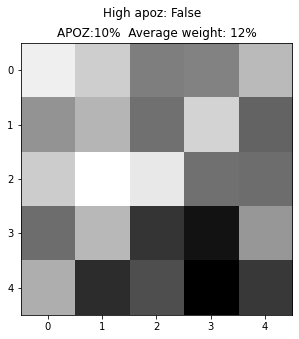

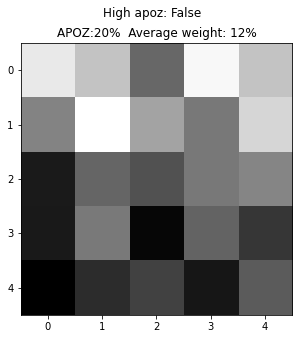

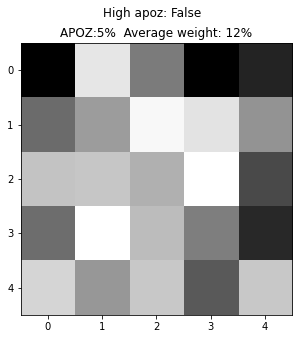

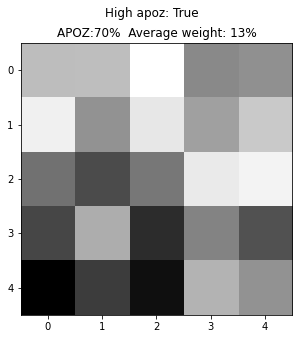

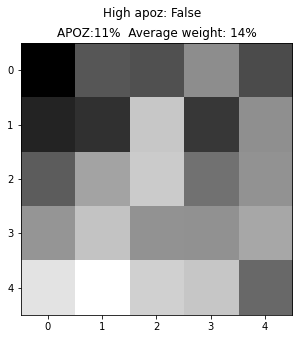

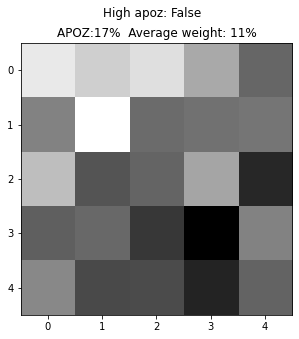

In [259]:
layer2 = model.get_layer("conv1")
print(np.shape(layer2.get_weights()[0]))
print(np.shape(layer2.get_weights()[0][:,:,0,0]))

apoz = kerassurgeon.identify.get_apoz(model, layer2, x_train)
print("Apoz:", apoz)
high_apoz_channels = kerassurgeon.identify.high_apoz(apoz, "both")
print("High apoz:", high_apoz_channels)

weights = layer2.get_weights()
num_of_filters = layer2.filters

for i in range(0, num_of_filters):
    filter = weights[0][:,:,0,i]
    plt.title("APOZ:" + str(int(apoz[i] * 100)) + "%")
    plt.suptitle("High apoz: " + str(i in high_apoz_channels))
    plt.imshow(filter, cmap="gray")
    plt.show()

In [158]:
layer = model.get_layer("conv1")
apoz = kerassurgeon.identify.get_apoz(model, layer, x_train)
print(np.shape(apoz))

(32,)


In [91]:
high_apoz_channels = kerassurgeon.identify.high_apoz(apoz, "both")
high_apoz_channels

array([ 0,  1,  8, 16, 18, 29, 31, 37])

In [92]:
model_pruned_export = kerassurgeon.operations.delete_channels(model_pruned_export, layer, high_apoz_channels)

Deleting 8/38 channels from layer: conv2


In [93]:
model_pruned_export.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 4, 4, 22)          5654      
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 2, 30)          5970      
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1210      
Total params: 12,834
Trainable params: 12,834
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
118/118 [==============================] - 2s 15ms/step - loss: 0.0309 - accuracy: 0.9907
Epoch 2/5
118/118 [==============================] - 2s 15ms/step - loss: 0.0282 - accuracy: 0.9914
Epoch 3/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0258 - accuracy: 0.9925
Epoch 4/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0234 - accuracy: 0.9930
Epoch 5/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0212 - accuracy: 0.9940


Text(0, 0.5, 'Accuracy')

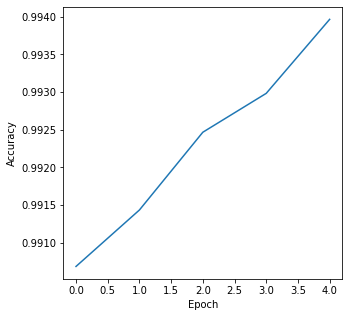

In [94]:
# Fit the model:
model_pruned_export.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [95]:
model_pruned_export.evaluate(x_train, y_train)

1875/1875 [==============================] - 2s 855us/step - loss: 1.9760 - accuracy: 0.4428


[1.94682776927948, 0.445250004529953]

In [16]:
from kerassurgeon import utils as k_utils

In [17]:
k_utils.find_nodes_in_model(model, model.get_layer("conv2"))

[0]

In [18]:
#Iterate thru all the layers of the model
for layer in model_pruned_export.layers:
    if 'conv2' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

NameError: name 'filters' is not defined